# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Выгрузим все нужные для проекта библиотеки (кроме библиотек для модели)

In [2]:
%%time

target_size = (224, 224)
random_seed = 12345

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
                    dataframe=labels,
                    directory='/datasets/faces/final_files/', 
                    x_col='file_name', 
                    y_col='real_age',
                    target_size=target_size,
                    batch_size=32, 
                    class_mode='raw',
                    seed=random_seed) 
labels.head(5)

Found 7591 validated image filenames.
CPU times: user 620 ms, sys: 456 ms, total: 1.08 s
Wall time: 1min 25s


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выгрузим данные и убедимся в правильности чтения файлов

--------------------
Среднее: 31.20115926755368
--------------------
Медиана: 29.0
--------------------
Мода: 0    30
dtype: int64
--------------------


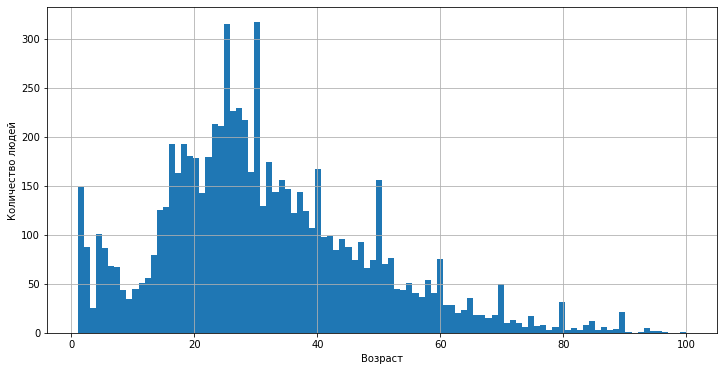

In [4]:
labels['real_age'].hist(bins=100, grid=True, figsize=(12, 6)).set(xlabel='Возраст', ylabel='Количество людей')

print('-'*20)
print('Среднее:', labels['real_age'].mean())
print('-'*20)
print('Медиана:', labels['real_age'].median()) 
print('-'*20)
print('Мода:', labels['real_age'].mode())
print('-'*20)

Построив гистограмму можно сделать вывод о том, что больше всего посетителей возрастом от 20 до 30 лет. Среднее равно 31, медиана равна 29, а мода равна 30. Также можно заметить, что пики на графике появляются на числах, которые целочисленно делятся на 5 или 10 (40, 50, 60 и т.д.)

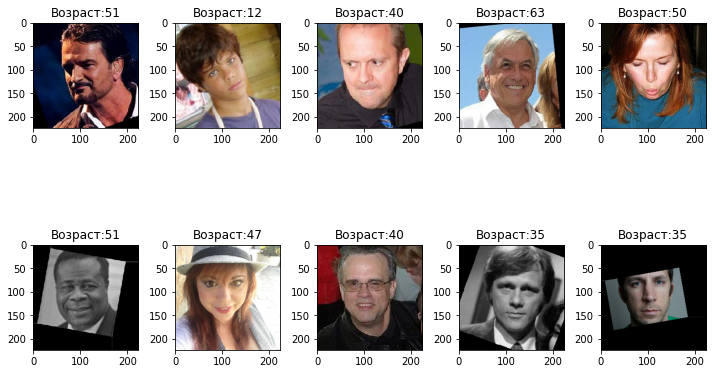

In [6]:
rows, cols = 3, 5
fig = plt.figure(figsize=(10, 10)) 
features, target = next(train_gen_flow) 

for i in range(10): 
    fig.add_subplot(rows, cols, i + 1) 
    plt.imshow(features[i]) 
    plt.title('Возраст:' + str(target[i]))
    plt.tight_layout()

Таким образом можно заметить, что датасет наполнен фотографиями разных людей, с указанным возрастом 

## Обучение модели

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=random_seed)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=random_seed)
    return train_datagen_flow

optimizer = Adam(learning_rate=0.0001)

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              epochs=epochs,
              batch_size=batch_size,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-08-11 00:37:54.422419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-11 00:37:54.752830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 205.2874 - mae: 10.3521 - val_loss: 416.4725 - val_mae: 15.3685
Epoch 2/10
356/356 - 42s - loss: 84.1298 - mae: 6.9572 - val_loss: 131.0865 - val_mae: 8.4685
Epoch 3/10
356/356 - 41s - loss: 57.2713 - mae: 5.7595 - val_loss: 82.8176 - val_mae: 6.9303
Epoch 4/10
356/356 - 41s - loss: 43.6142 - mae: 5.0172 - val_loss: 80.6735 - val_mae: 6.7813
Epoch 5/10
356/356 - 42s - loss: 31.9264 - mae: 4.3341 - val_loss: 103.6210 - val_mae: 7.7296
Epoch 6/10
356/356 - 41s - loss: 26.7875 - mae: 3.9515 - val_loss: 72.7362 - val_mae: 6.2304
Epoch 7/10
356/356 - 41s - loss: 20.1204 - mae: 3.4201 - val_loss: 67.7394 - val_mae: 6.2231
Epoch 8/10
356/356 - 41s - loss: 15.4851 - mae: 2.9992 - val_loss: 75.7471 - val_mae: 6.4272
Epoch 9/10
356/356 - 41s - loss: 13.8078 - mae: 2.8219 - val_loss: 68.7386 - val_mae: 6.4036
Epoch 10/10
356/356 - 41s - loss: 12.5589 - mae: 2.6912 - val_loss: 79.7618 - val_mae: 6.8988
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 79.7618 - mae: 6.8988
Test MAE: 6.8988

```

## Анализ обученной модели

Можно заключить, что в рамках проекта был проанализирован датасет с возрастами людей, а также сгенерирован датасет, по которому впоследствии нейронная сеть была обучена. Цель проекта -- построить нейронную сеть, которая сможет предсказывать возраст посетителя с коэффициентом mean absolute error < 8. Однако можно сказать, что модель переобучена, потому что в выгруженном логе присутствует большая разница между метриками на обучении и валидации. 

Также можно заметить нестабильность и рост ошибки на валидации ближе к концу обучения. Для того, чтобы избежать переобучения, можно сократить количество эпох в модели, например, до 7, где MAE на валидационной выборке составляет 6.2231. Также можно использовать методы регуляризации и Dropout:

```python
from tensorflow.keras.layers import Dropout

model.add(Dropout(0.5))
```


Таким образом поставленная цель была выполнена, MAE составил 6.8988, что говорит о том, что в среднем модель ошибается в возрасте на 7 лет. Мне кажется, что внеся некоторые изменения, а также проработав переобученность, модель можно внедрять для использования в магазинах. В основном акцент стоит сделать на точности прогнозов. Максимизируя точность прогнозов можно добиться большей вероятности, что модель хорошо покажет себя в использовании на практике. 